## Setup
- Imports
- Load and preprocess data

In [4]:
import torch
import torch.nn.functional as F

In [7]:
vocab = [] # all poosible characters in the training corpus
itoc = {} # index to character mapping
ctoi = {} # character to index mapping
for i in range(26):
    c = chr(i+ord('a'))
    vocab.append(c)
    ctoi[c] = i+1
    itoc[i+1] = c

vocab.append('.')
itoc[0] = '.'
ctoi['.'] = 0
vocab_size = len(vocab)

In [2]:
with open('./names.txt', 'r') as f:
    words = [word.strip() for word in f.readlines()]

In [5]:
block_size = 3 # previous context size
def create_dataset(names):
    X = []
    y = []
    for name in names:
        context = [0]*block_size # initialize previous context of each word with '...', which translates to [0,0,0] indices in the vocab
        for c in name.strip() + '.': # append '.' to the end of name to capture ending sequences of each name
            label = ctoi[c] # vocab index of the current character in name
            X.append(context)
            y.append(label)
            context = context[1:] + [label]
    return torch.tensor(X), torch.tensor(y)

import random
random.seed(1937)
random.shuffle(words) # randomly shuffles the list of words, reduces the gap between train/dev errors! WHY??!
total_data_size = len(words)
train_size = int(total_data_size*0.8)
dev_size = int(total_data_size*0.1)
Xtr, ytr = create_dataset(words[:train_size])
Xdev, ydev = create_dataset(words[train_size:train_size+dev_size])
Xtest, ytest = create_dataset(words[train_size+dev_size:])


## Build the MLP
- will be used as reference for explanations ahead in the code

In [39]:
g = torch.Generator().manual_seed(66449941) # for reproducibility
vocab_size = len(vocab)
emb_dimensions = 10
hidden_layer_size = 200
output_layer_size = vocab_size
C = torch.randn((vocab_size, emb_dimensions), generator=g)
W1 = torch.randn((block_size*emb_dimensions, hidden_layer_size), generator = g)
b1 = torch.randn((hidden_layer_size), generator=g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)
b2 = torch.randn((output_layer_size), generator = g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

total_parameters = sum(p.nelement() for p in parameters)
total_parameters

9367

In [41]:
log_losses = []
num_iterations = 200000
mini_batch_size = 32

for i in range(num_iterations):
    # randomly sample minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    a1 = torch.tanh((emb.view(-1, block_size*emb_dimensions) @ W1 + b1))
    logits = a1 @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    if i%10000==0:
        print(f'{i:7d}/{num_iterations:7d}: {loss.item():.4f}') # 7d aligns the outputs for readability
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    learning_rate = 0.1 if i < num_iterations//2 else 0.01
    for p in parameters:
        p.data += -learning_rate*p.grad
    log_losses.append(loss.log10().item())

      0/ 200000: 17.0453
  10000/ 200000: 2.1651
  20000/ 200000: 2.3421
  30000/ 200000: 2.5685
  40000/ 200000: 2.0644
  50000/ 200000: 2.3014
  60000/ 200000: 2.2805
  70000/ 200000: 2.4262
  80000/ 200000: 2.0969
  90000/ 200000: 2.2885
 100000/ 200000: 2.2696
 110000/ 200000: 2.2033
 120000/ 200000: 2.1952
 130000/ 200000: 2.4137
 140000/ 200000: 2.1973
 150000/ 200000: 2.1784
 160000/ 200000: 2.5361
 170000/ 200000: 2.2473
 180000/ 200000: 2.0071
 190000/ 200000: 2.1565


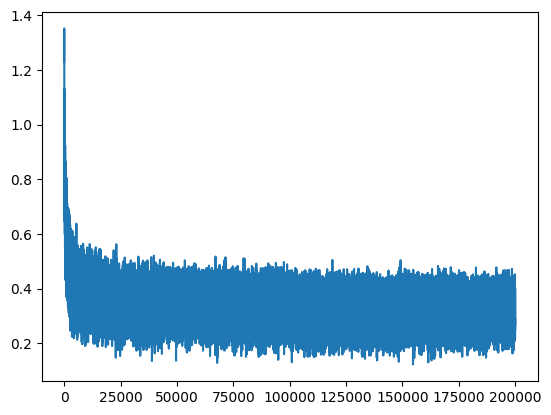

In [42]:
from matplotlib import pyplot as plt
plt.plot(log_losses)

In [29]:
@torch.no_grad()
def evaluate(split):
    X, y = {'train':[Xtr, ytr],
            'dev':[Xdev, ydev],
            'test':[Xtest, ytest]
            }[split]
    emb = C[X]
    a1 = torch.tanh(emb.view(-1, block_size*emb_dimensions) @ W1 + b1)
    logits = a1 @ W2 + b2
    return F.cross_entropy(logits, y).item()

In [43]:
evaluate('train'), evaluate('dev'), evaluate('test')

(2.115313768386841, 2.1721436977386475, 2.1816470623016357)

## Fixing initial loss

#### expected inital loss
- first we need to set the right expectations
- what can be the worst possible initial loss?
    - depends on the problem and the loss function
    - almost always possible to estimate this quantity beforehand
    - helps start strong in training loop
- In our case worst loss intial loss:
    - negative log likelihood
    - worst possible model would be when the prob of each token coming next is equal = 1/vocab_size => model hasen't learnt anything
    - we take only 1/vocab_size [single probability] as we are predicting single token
    - in our case that's prob = 1/27.0 => negative log likelihood = -log(prob) ~ (3,4)
- but the initial loss we got is 17 which is way off [though its averaged over 1st mini-batch]
- this is due to improper initialization of parameters

In [47]:
expected_loss = -torch.tensor(1/27.0).log()
expected_loss

tensor(3.2958)

#### example of issue
- vocab = [a, b, c, d], vocab_size = 4
- if logits are almost equal, the softmax probs would also be almost equal and
- hence the loss would be approx equal to expected loss = -log(1/4.0) ~ 1.39

In [49]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0]) # say we got these logits from the intial model parameters [0th iteration -> no learning yet]
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # peek into the probability of the token 'c' appearing next and calculate the nll
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

- as we can see, equal probabilities and hence got expected loss
- another example
    - say due to initialization we accidentally get too high logit value for the expected next token in the minibatch examples
    - and very low logits for the other tokens
    - then initial loss would be very low than expected worst case!!

In [50]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0]) # high logit for 'c' token
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # peek into the probability of the token 'c' appearing next and calculate the nll
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

- loss is almost zero!!
- another example
    - now let's set logits higher for unexpected tokens and lower for expected token
    - loss would be higher than expected worst case

In [51]:
logits = torch.tensor([0.0, 5.0, 0.0, 0.0]) # high logit for 'c' token
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # peek into the probability of the token 'c' appearing next and calculate the nll
probs, loss

(tensor([0.0066, 0.9802, 0.0066, 0.0066]), tensor(5.0200))

- let's now experiment with logits drawn from gaussian distribution (0,1)
    - if we try executing the below cell multiple times, we may get loss anywhere between (0,5-6)
    - still okay as the logits will be somewhere between -3 and 3 mostly (6-sigma)

In [94]:
logits = torch.randn(4) # values drawn from normal dist, hence mostly close to zero
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # peek into the probability of the token 'c' appearing next and calculate the nll
logits, probs, loss

(tensor([ 1.6604,  0.3079, -0.4316,  0.8718]),
 tensor([0.5445, 0.1408, 0.0672, 0.2475]),
 tensor(2.6998))

- if we use very extreme values (far away from 0), we might get very high/low loss

In [97]:
logits = torch.randn(4)*10 # now logits mostly lie between [-30, 30] 6-sigma*10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # peek into the probability of the token 'c' appearing next and calculate the nll
logits, probs, loss

(tensor([11.3478,  3.8213,  2.0427,  1.5920]),
 tensor([9.9931e-01, 5.3826e-04, 9.0898e-05, 5.7919e-05]),
 tensor(9.3058))

In [102]:
logits = torch.randn(4)*100 # now logits mostly lie between [-300, 300] 6-sigma*100
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # peek into the probability of the token 'c' appearing next and calculate the nll
logits, probs, loss

(tensor([-41.6019, 195.6921, -70.2348,  61.4994]),
 tensor([0., 1., 0., 0.]),
 tensor(inf))

Summary:
- we want the logits to be equal initially to get the expected loss
- can be any number (remember softmax in shift invariant! refer previous notebooks)
- better to stick with 0 initialization

#### Fix issue in model params

from prev section:
- we need to get the logits as close to 0 and as equal in magnitude as possible
- how can we achieve this?
    - observe the computation of logits
    - logits = 
    - setting the last layer weights and biases to 0 W2=b2=0 [this can lead to problems as discussed later in this notebook]
    - instead set W2 to very low values close to 0 and b2 to exactly 0

In [112]:
g = torch.Generator().manual_seed(66449941)
vocab_size = len(vocab)
emb_dimensions = 10
hidden_layer_size = 200
output_layer_size = vocab_size
C = torch.randn((vocab_size, emb_dimensions), generator=g)
W1 = torch.randn((block_size*emb_dimensions, hidden_layer_size), generator = g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)*0.01
b2 = torch.randn((output_layer_size), generator = g)*0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

total_parameters = sum(p.nelement() for p in parameters)
total_parameters

11897

In [113]:
log_losses = []
steps = []
num_iterations = 200000
mini_batch_size = 32

for i in range(num_iterations):
    # randomly sample minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    a1 = torch.tanh((emb.view(-1, block_size*emb_dimensions) @ W1 + b1))
    logits = a1 @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    if i%10000==0:
        print(f'{i:7d}/{num_iterations:7d}: {loss.item():.4f}') # 7d aligns the outputs for readability
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    learning_rate = 0.1 if i < num_iterations//2 else 0.01
    for p in parameters:
        p.data += -learning_rate*p.grad

    steps.append(i)
    log_losses.append(torch.log10(loss).item())

      0/ 200000: 3.2818
  10000/ 200000: 1.9967
  20000/ 200000: 2.1044
  30000/ 200000: 2.3582
  40000/ 200000: 2.5299
  50000/ 200000: 2.3278
  60000/ 200000: 1.9905
  70000/ 200000: 2.2069
  80000/ 200000: 2.1595
  90000/ 200000: 2.5824
 100000/ 200000: 1.9348
 110000/ 200000: 2.0562
 120000/ 200000: 2.4081
 130000/ 200000: 2.2449
 140000/ 200000: 2.0295
 150000/ 200000: 1.7764
 160000/ 200000: 1.9497
 170000/ 200000: 1.5519
 180000/ 200000: 1.8551
 190000/ 200000: 2.0702


- we got a initial loss close to the expected worst case loss!

In [115]:
# scrutinize the logits for 1st example
logits[0]

tensor([ 2.5992,  3.6125,  3.3218, -0.4748, -1.2843,  3.0023, -2.8475,  0.8144,
        -3.0743,  3.7589, -1.1597, -2.9218, -0.8701,  2.4202, -0.1275,  3.5110,
         0.8811, -3.5731,  1.0918,  0.4604, -3.5638,  1.6311, -3.7558, -2.9542,
        -2.7588,  1.4990,  0.5648], grad_fn=<SelectBackward0>)

- small numbers close to zero as expected
- let's also visualize the log loss plot with steps

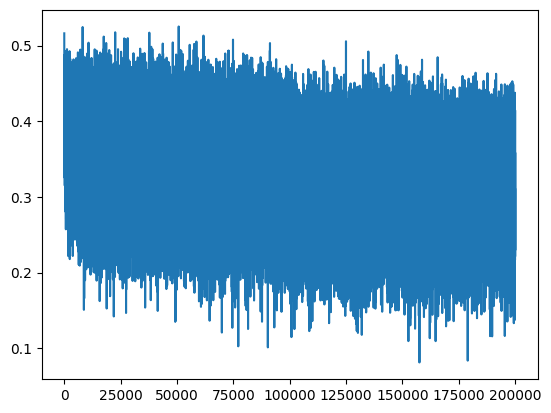

In [114]:
from matplotlib import pyplot as plt
plt.plot(log_losses)

- notice how the hockey stick like loss curve has changed to the unstable part only
- because, earlier NN was able to squash the final logits and learn quickly in the initial iterations
- now we took the easier part away by better param initialization
- the hard part remains

let's also check the dev loss

In [117]:
evaluate('train'), evaluate('dev'), evaluate('test')

(2.064671516418457, 2.1371400356292725, 2.147270679473877)

the loss actually improved on all three splits!
- mainly because we let the model focus more on the actual learning part
- and not the logit squashing part
- hence, initialization part has been taken care of

There is another problem in the NN:
- the activations
- we have used tanh activation function that maps Real numbers between -1 and 1
- 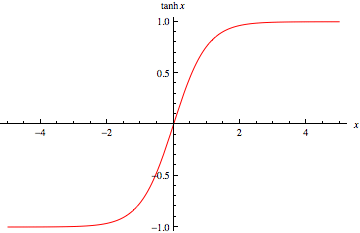

- notice how the activations would be mostly close to 1 and -1 if the tanh abs input value is >=2.5
- this also means the gradients would be close to 0 and minimal updates to the NN params!

## Activation issue
- let's analyze the activations of the hidden layer for better intuition

#### activations analysis thru dist, visualization

In [127]:
g = torch.Generator().manual_seed(66449941)
vocab_size = len(vocab)
emb_dimensions = 10
hidden_layer_size = 200
output_layer_size = vocab_size
C = torch.randn((vocab_size, emb_dimensions), generator=g)
W1 = torch.randn((block_size*emb_dimensions, hidden_layer_size), generator = g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)*0.01
b2 = torch.randn((output_layer_size), generator = g)*0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

total_parameters = sum(p.nelement() for p in parameters)
total_parameters

11897

In [128]:

log_losses = []
steps = []
num_iterations = 200000
mini_batch_size = 32

for i in range(num_iterations):
    # randomly sample minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    z1 = (emb.view(-1, block_size*emb_dimensions) @ W1 + b1)
    a1 = torch.tanh(z1)
    logits = a1 @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    if i%10000==0:
        print(f'{i:7d}/{num_iterations:7d}: {loss.item():.4f}') # 7d aligns the outputs for readability
    break # to see the activations and analyze
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    learning_rate = 0.1 if i < num_iterations//2 else 0.01
    for p in parameters:
        p.data += -learning_rate*p.grad

    steps.append(i)
    log_losses.append(torch.log10(loss).item())

      0/ 200000: 3.3376


In [129]:
# activations - see how most of them are close to one
a1

tensor([[ 1.0000,  0.3330, -0.9425,  ..., -0.9862, -1.0000, -0.9986],
        [-0.8950,  0.9878,  0.9589,  ...,  0.4622, -0.9999,  0.7508],
        [ 0.9901, -0.9997, -0.9976,  ...,  0.9999, -1.0000, -0.9996],
        ...,
        [-1.0000,  1.0000,  0.9999,  ...,  0.9912,  1.0000, -1.0000],
        [-0.9997, -0.8327,  0.9912,  ...,  1.0000, -1.0000, -0.9464],
        [-1.0000, -0.9999,  1.0000,  ..., -0.9973, -1.0000, -0.6694]],
       grad_fn=<TanhBackward0>)

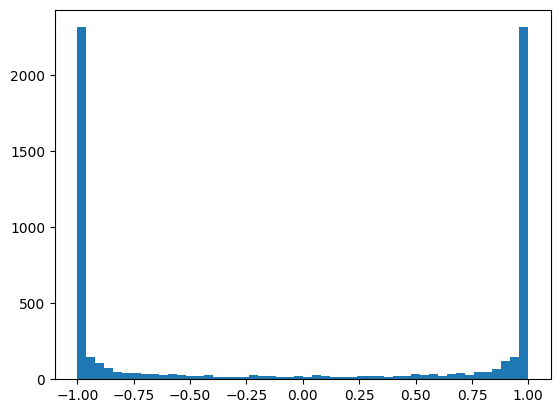

In [130]:
# drawing histogram
activations = a1.view(-1).tolist()
plt.hist(activations, bins = 50); # semi-colon suppresses the unwanted output

why mostly close to 1 or -1?
- check tanh input dist

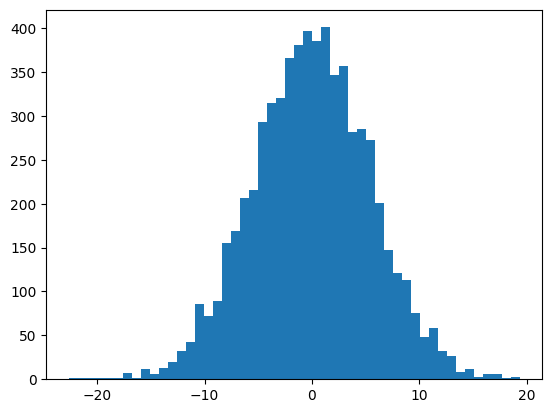

In [131]:
plt.hist(z1.view(-1).tolist(), 50);

In [143]:
# number of abs values greater than 2.5
total_preactivations = z1.view(-1).shape[0]
tail_region_preactivations = torch.where(torch.abs(z1.view(-1)) > 2.5)[0].shape[0]
tail_region_preactivations, total_preactivations

(4146, 6400)

- range of values of the pre-activations is very broad [-15, 15]
- majority lie in the tail/flat region of tanh as seen in prev cell

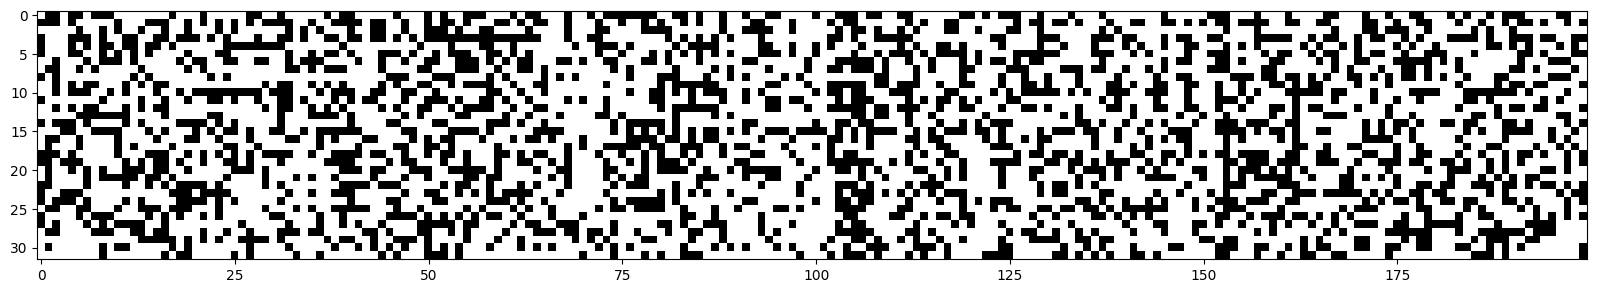

In [147]:
# we an even visualize the activations in a better way
plt.figure(figsize=(20,10))
plt.imshow(a1.abs()>0.99, cmap='gray', interpolation='nearest') # white means how many activations are close to 1
# 32x200 sized boolean tensor of activation absolute values > 0.99

majority are whites
- this represents 32 examples in the minibatch and the 200 neurons in hidden layer
- if by any chance the weights and biases are initialized such that 
- one of the neurons has activations 1 for all the examples, that neuron won't be learning!!
- dL/dz = (dL/da)*(da/dz) = (dL/da)*0.00000000001 ~ 0
- z = z - dL/dz; z = z => hence, the weights and biases coming in to this neuron won't update => DEAD NEURON
- not only the gradient part, but for some activation functions like ReLU, if the learning rate is too high, some activations might get knocked out into the flat region leading to permanent damage [no learning ever after]

#### How do we solve for this issue?
- similar to previous issue, where we set the weights and biases so that logits are closer to 0 and more uniform
- we would set the weights and biases leading to the pre-activations to lower values close to 0
- this would force pre-activations closer to 0 [-1, 1] and hence push activations in the active region of tanh

In [159]:
g = torch.Generator().manual_seed(66449941)
vocab_size = len(vocab)
emb_dimensions = 10
hidden_layer_size = 200
output_layer_size = vocab_size
C = torch.randn((vocab_size, emb_dimensions), generator=g)
W1 = torch.randn((block_size*emb_dimensions, hidden_layer_size), generator = g)*0.2
b1 = torch.randn(hidden_layer_size, generator=g)*0.01
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)*0.01
b2 = torch.randn((output_layer_size), generator = g)*0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

total_parameters = sum(p.nelement() for p in parameters)
total_parameters

11897

In [154]:

log_losses = []
steps = []
num_iterations = 200000
mini_batch_size = 32

for i in range(num_iterations):
    # randomly sample minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    z1 = (emb.view(-1, block_size*emb_dimensions) @ W1 + b1)
    a1 = torch.tanh(z1)
    logits = a1 @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    if i%10000==0:
        print(f'{i:7d}/{num_iterations:7d}: {loss.item():.4f}') # 7d aligns the outputs for readability
    break # to see the activations and analyze
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    learning_rate = 0.1 if i < num_iterations//2 else 0.01
    for p in parameters:
        p.data += -learning_rate*p.grad

    steps.append(i)
    log_losses.append(torch.log10(loss).item())

      0/ 200000: 3.3022


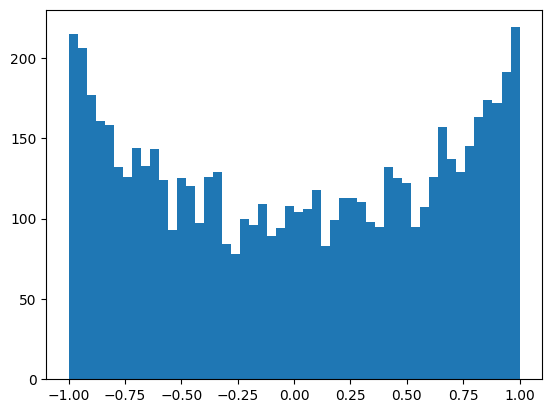

In [155]:
plt.hist(a1.view(-1).tolist(), bins = 50);

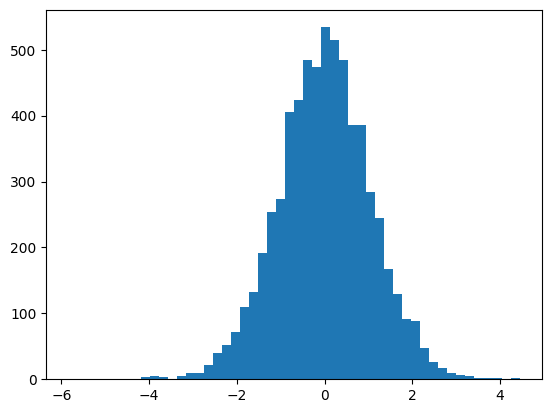

In [156]:
plt.hist(z1.view(-1).tolist(), 50);

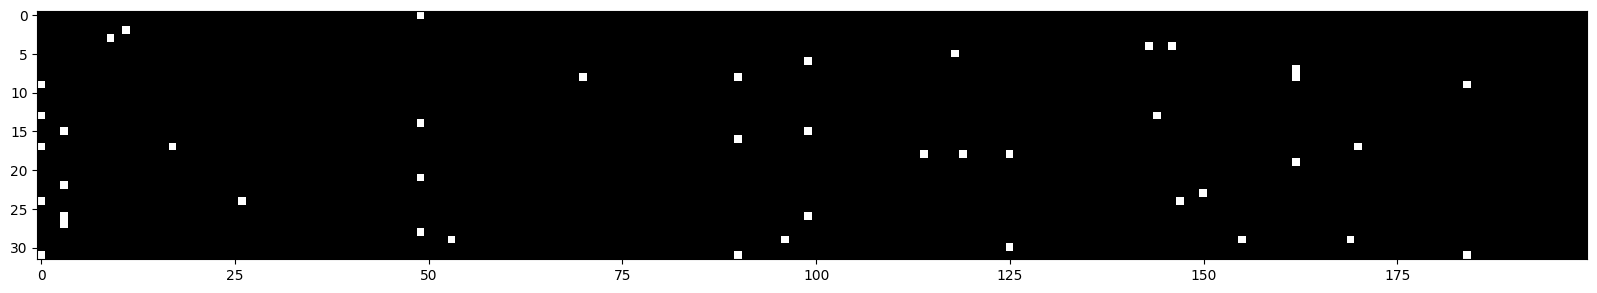

In [158]:
plt.figure(figsize=(20,10))
plt.imshow(a1>0.99, cmap='gray', interpolation='nearest')

- most activations are now in active region
- let's retrain the model with this config now

#### re-training post activation fix

In [160]:

log_losses = []
steps = []
num_iterations = 200000
mini_batch_size = 32

for i in range(num_iterations):
    # randomly sample minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    z1 = (emb.view(-1, block_size*emb_dimensions) @ W1 + b1)
    a1 = torch.tanh(z1)
    logits = a1 @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    if i%10000==0:
        print(f'{i:7d}/{num_iterations:7d}: {loss.item():.4f}') # 7d aligns the outputs for readability

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    learning_rate = 0.1 if i < num_iterations//2 else 0.01
    for p in parameters:
        p.data += -learning_rate*p.grad

    steps.append(i)
    log_losses.append(torch.log10(loss).item())

      0/ 200000: 3.3095
  10000/ 200000: 2.4105
  20000/ 200000: 2.1044
  30000/ 200000: 2.1873
  40000/ 200000: 1.8532
  50000/ 200000: 1.8612
  60000/ 200000: 2.0871
  70000/ 200000: 2.0384
  80000/ 200000: 2.3845
  90000/ 200000: 1.7818
 100000/ 200000: 1.9241
 110000/ 200000: 2.1661
 120000/ 200000: 2.0970
 130000/ 200000: 2.3377
 140000/ 200000: 1.9109
 150000/ 200000: 2.1244
 160000/ 200000: 2.0043
 170000/ 200000: 1.5509
 180000/ 200000: 2.2036
 190000/ 200000: 2.3006


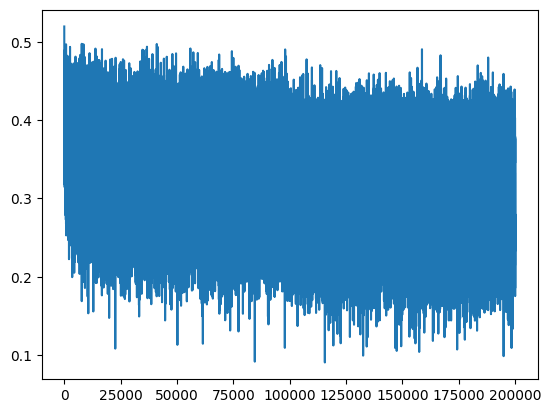

In [161]:
plt.plot(log_losses)

In [162]:
evaluate('train'), evaluate('dev'), evaluate('test')

(2.036219835281372, 2.109724283218384, 2.118234395980835)

Losses on train/dev:
- stage:             train,  dev
- initial:           2.12,   2.17
- logits fix:        2.07,   2.14
- activations fix:   2.04,   2.11

we have made improvements but we are heavily dependent on scaling the initialized parameters. We came up with random set of scaling factors which obviously is not the best way to solve these issues.
- Let's look at how we can account for this much elegantly

## Kaiming Normalization

#### Proof of concept

tensor(-0.0094) tensor(0.9982)
tensor(0.0038) tensor(3.1372)


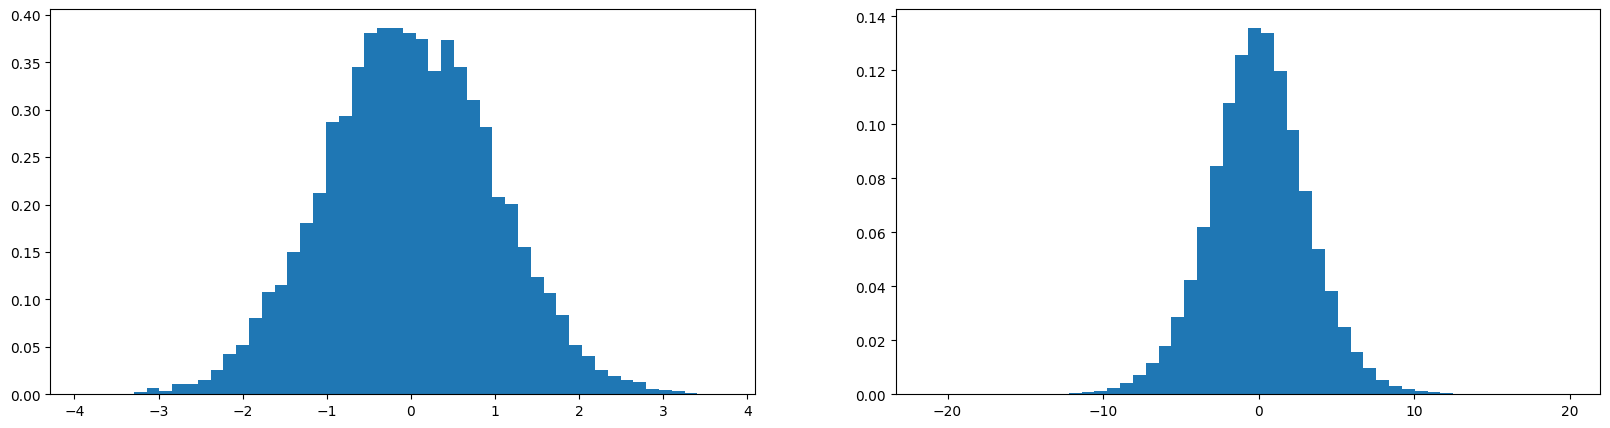

In [164]:
x = torch.randn(1000, 10) # 1000 examples drawn from gaussian; 10d input
w = torch.randn(10, 200) # gaussian weights 10; 200 output size
y = x@w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

- x mean is 0 and std 1 which is expected
- y mean is 0 as x@w is symmetric operation
- but y std is 3 => broader gaussian
- what we want is unit gaussians throughout the network to ensure we hit the active regions of the activation functions
- we have seen earlier, scaling down the weights w can solve this issue
- but what is the scaling factor?

tensor(-0.0124) tensor(0.9915)
tensor(0.0015) tensor(1.0097)


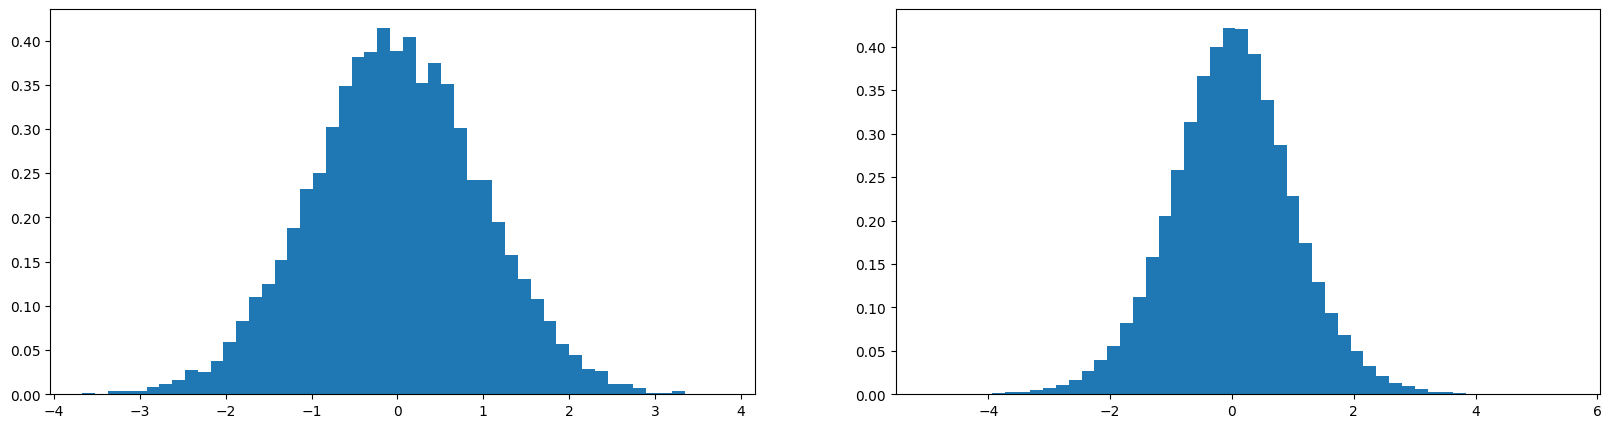

In [169]:
x = torch.randn(1000, 10) # 1000 examples drawn from gaussian; 10d input
w = torch.randn(10, 200)*(1/10**0.5) # gaussian weights input size 10; 200 output size
y = x@w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

- scaling factor of 0.2 reduced the std to 0.62 which is too low
- scaling factor of 0.6 lead to std = 1.9 too high
- how do we find the sweet spot for scaling factor??
- one idea is kaiming scaling of either activations or gradients in forward or bacward pass respectively; refer [paper](https://arxiv.org/abs/1502.01852)
- kaiming normalization factor in forward pass = activation_gain/(fan_in_layre_size**0.5)
- activation_gain is specific to the activation function
- above example is linear activation/no activation, hence the gain is 1 and factor is 1/(10**0.5)
- now the std of y's comes out to be 1

gain for tanh is 5/3; fan-in is emb_dimension*block_size
- comes out to be 0.3 which is very close to 0.2 that we tried out
- hence no point in re-training, we would get similar results

## Batch Normalization

What we were trying to do till now is find a scaling factor to bring the hidden states/preactivations and hence the activations in the active part of the activation function. This scaling factor would make the hidden states roughly normal dist (0, 1).
Batch Normalization [paper](https://arxiv.org/abs/1502.03167) is a simple idea - instead of finding this scaling factor, normalize the hidden states across the mini-batch and force them to be ~ N(0, 1) initially. Later the NN is free to modify these as suitable. Our job is to start the learning at a point from where the model learns better/faster and focuses more on the actual learning
- the paper proposes the idea in the following equations:
- 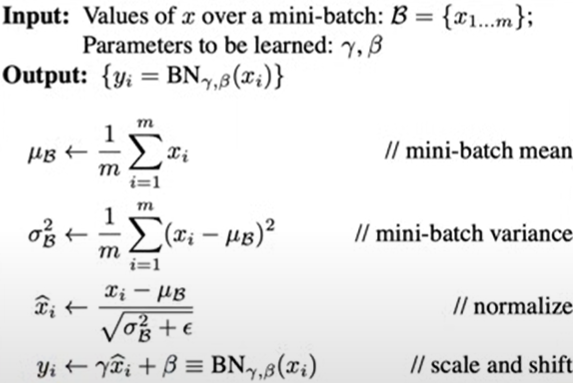
- gamma and beta are initialized such that the first iteration still has activations ~ N(0,1)
- that means, gamma = 1 and beta = 0

#### re-initialize MLP

- add the Batch Normalization (BN) parameters: BN gain, BN bias
- initialize them correctly
- implement batch norm using mean, std with correct dimension [we want to normalize across minibatch, hence dim=0]
- 32x200 -> mean along 0 dim 1x200, std along 0 dim 1x200; broadcasted and applied to each example

In [8]:
g = torch.Generator().manual_seed(66449941)
vocab_size = len(vocab)
emb_dimensions = 10
hidden_layer_size = 200
output_layer_size = vocab_size
C = torch.randn((vocab_size, emb_dimensions), generator=g)
W1 = torch.randn((block_size*emb_dimensions, hidden_layer_size), generator = g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)*0.01
b2 = torch.randn((output_layer_size), generator = g)*0

# BN parameters:
bngamma = torch.ones((1, hidden_layer_size)) # after norm, the 32x200 would be multiplied with gamma 1x200 broadcasted to multiply each row (example) with the same gamma
bnbeta = torch.zeros((1, hidden_layer_size)) # same broadcasting as gamma
# also called BN gain and BN bias

# also add to parameters list
parameters = [C, W1, b1, W2, b2, bngamma, bnbeta]

for p in parameters:
    p.requires_grad = True

total_parameters = sum(p.nelement() for p in parameters)
total_parameters

12297

In [9]:
log_losses = []
steps = []
num_iterations = 200000
mini_batch_size = 32

for i in range(num_iterations):
    # randomly sample minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    z1 = (emb.view(-1, block_size*emb_dimensions) @ W1 + b1)

    # Implement Batch Normalization
    z1 = bngamma * (z1 - z1.mean(dim=0))/z1.std(dim=0) + bnbeta # notice * instead of @ as we want element wise product
    
    a1 = torch.tanh(z1)
    logits = a1 @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    if i%10000==0:
        print(f'{i:7d}/{num_iterations:7d}: {loss.item():.4f}') # 7d aligns the outputs for readability

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    learning_rate = 0.1 if i < num_iterations//2 else 0.01
    for p in parameters:
        p.data += -learning_rate*p.grad

    steps.append(i)
    log_losses.append(torch.log10(loss).item())

      0/ 200000: 3.2913
  10000/ 200000: 2.3318
  20000/ 200000: 2.5287
  30000/ 200000: 1.9548
  40000/ 200000: 2.2450
  50000/ 200000: 1.9787
  60000/ 200000: 2.1909
  70000/ 200000: 2.0791
  80000/ 200000: 2.7539
  90000/ 200000: 2.3853
 100000/ 200000: 2.2046
 110000/ 200000: 2.0082
 120000/ 200000: 2.4977
 130000/ 200000: 2.4928
 140000/ 200000: 2.0667
 150000/ 200000: 2.1572
 160000/ 200000: 2.0257
 170000/ 200000: 2.0306
 180000/ 200000: 2.2005
 190000/ 200000: 2.2124


Batch Norm in all forward passes -> remember to implement batch norm in eval function as well!!

In [10]:
@torch.no_grad()
def evaluate(split):
    X, y = {'train':[Xtr, ytr],
            'dev':[Xdev, ydev],
            'test':[Xtest, ytest]
            }[split]
    emb = C[X]
    z1 = emb.view(-1, block_size*emb_dimensions) @ W1 + b1
    # Implement Batch Normalization
    z1 = bngamma * (z1 - z1.mean(dim=0))/z1.std(dim=0) + bnbeta # notice * instead of @ as we want element wise product
    
    a1 = torch.tanh(z1)
    logits = a1 @ W2 + b2
    return F.cross_entropy(logits, y).item()

In [12]:
evaluate('train'), evaluate('dev'), evaluate('test')

(2.108396053314209, 2.1460890769958496, 2.152794122695923)

Losses on train/dev:
- stage:                train,  dev
- initial:              2.12,   2.17
- logits fix:           2.07,   2.14
- activations fix:      2.04,   2.11
- batch normalization:  2.11,   2.15

Batch Normalization did not actually improve the metrics as this is a small and simple example. But its impactful in larger and deeper nets
- Some observations around Batch Normalization:
    - Batch Norm actually is not ideal since it entangles all the minibatch examples together
    - all training examples are supposed to be independently making the network learn
    - BN couples them making the pre-activations noisy
    - it can lead to nasty bugs [paper](https://arxiv.org/abs/2105.07576)
    - not used much anymore, alternatives: layer norm, etc.
    - a side effect of this is regularization from the noise thus introduced
    - preventing the model from overfitting

BN does have one more catch
- during training we had batches for normalizing
- in testing/production if we get single examples how do we account for the mean and std??
- paper proposes to use the mean and std of the entire training set and lock them as constants for inference time
- this can be done in 2 ways:
    - one forward pass for entire train set after the training is complete to get mean, std
    - running mean, std in the training loop itself
- both give similar values but 2nd is preferred, better abstraction; no explict extra computation post training loop
- pytorch also implemented 2nd method

#### method 1 - explicit

In [15]:
# calibrate batch norm at end of training

# no grads required
with torch.no_grad():
    # entire train set
    emb = C[Xtr]
    z1 = emb.view(emb.shape[0], -1) @ W1 + b1 # z1 is pre-activations or hidden states
    # measure the mean, std over the entire train set
    bnmean = z1.mean(dim=0, keepdim=True) # keepdim doesn't matter here, but to be on safer side
    bnstd = z1.std(dim=0, keepdim=True)

#### method 2 - running mean

In [22]:
g = torch.Generator().manual_seed(66449941)
vocab_size = len(vocab)
emb_dimensions = 10
hidden_layer_size = 200
output_layer_size = vocab_size
C = torch.randn((vocab_size, emb_dimensions), generator=g)
W1 = torch.randn((block_size*emb_dimensions, hidden_layer_size), generator = g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)*0.01
b2 = torch.randn((output_layer_size), generator = g)*0

# BN parameters:
bngamma = torch.ones((1, hidden_layer_size)) # after norm, the 32x200 would be multiplied with gamma 1x200 broadcasted to multiply each row (example) with the same gamma
bnbeta = torch.zeros((1, hidden_layer_size)) # same broadcasting as gamma
# also called BN gain and BN bias

# initialize the runnning means of mean, std
# since initially we have mean 0 and std 1
bnmean_running = torch.zeros((1, hidden_layer_size))
bnstd_running = torch.ones((1, hidden_layer_size))
# donot add to parameters as these don't require grad/training

# also add to parameters list
parameters = [C, W1, b1, W2, b2, bngamma, bnbeta]

for p in parameters:
    p.requires_grad = True

total_parameters = sum(p.nelement() for p in parameters)
total_parameters

12297

In [23]:
log_losses = []
steps = []
num_iterations = 200000
mini_batch_size = 32

for i in range(num_iterations):
    # randomly sample minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    z1 = (emb.view(-1, block_size*emb_dimensions) @ W1 + b1)

    # Implement Batch Normalization
    bnmeani = z1.mean(dim=0, keepdim=True)
    bnstdi = z1.std(dim=0, keepdim=True)
    z1 = bngamma * (z1 - bnmeani)/bnstdi + bnbeta # notice * instead of @ as we want element wise product

    # keep track of running mean but BEWARE! Keep this computations outside the grad graph
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
        # exponential mean to be precise

    a1 = torch.tanh(z1)
    logits = a1 @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    if i%10000==0:
        print(f'{i:7d}/{num_iterations:7d}: {loss.item():.4f}') # 7d aligns the outputs for readability
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    learning_rate = 0.1 if i < num_iterations//2 else 0.01
    for p in parameters:
        p.data += -learning_rate*p.grad

    steps.append(i)
    log_losses.append(torch.log10(loss).item())

      0/ 200000: 3.2898
  10000/ 200000: 2.2512
  20000/ 200000: 2.4204
  30000/ 200000: 2.7880
  40000/ 200000: 2.1608
  50000/ 200000: 2.0847
  60000/ 200000: 2.3476
  70000/ 200000: 2.2526
  80000/ 200000: 2.2512
  90000/ 200000: 2.2510
 100000/ 200000: 1.9584
 110000/ 200000: 2.0129
 120000/ 200000: 2.0970
 130000/ 200000: 2.0517
 140000/ 200000: 1.7728
 150000/ 200000: 2.3207
 160000/ 200000: 1.9804
 170000/ 200000: 2.3732
 180000/ 200000: 2.1321
 190000/ 200000: 1.7652


In [25]:
deviation_of_the_differences1 = (bnmean - bnmean_running).std(dim = 1)
deviation_of_the_differences2 = (bnstd - bnstd_running).std(dim=1)
deviation_of_the_differences1.item(), deviation_of_the_differences2.item() # should be small

(0.6327077150344849, 0.1939246505498886)

re-implement eval function using running means

In [26]:
@torch.no_grad()
def evaluate(split):
    X, y = {'train':[Xtr, ytr],
            'dev':[Xdev, ydev],
            'test':[Xtest, ytest]
            }[split]
    emb = C[X]
    z1 = emb.view(-1, block_size*emb_dimensions) @ W1 + b1
    # Implement Batch Normalization
    z1 = bngamma * (z1 - bnmean_running)/bnstd_running + bnbeta # notice * instead of @ as we want element wise product
    
    a1 = torch.tanh(z1)
    logits = a1 @ W2 + b2
    return F.cross_entropy(logits, y).item()

In [27]:
evaluate('train'), evaluate('dev'), evaluate('test')

(2.1098098754882812, 2.1466541290283203, 2.1539244651794434)

got identical losses

Few more notes on BN:
- epsilon was not added in our example
    - it just ensures no div by 0
- the bias terms just before the BN step don't matter anymore
    - z1 = emb@W1 + b1; z1 - z1.mean() => subtracts out the b1's! b1 grads would be 0 and they won't be updated
    - unnecessary extra computation
    - hence we remove the bias b1 and treat the `bnbeta` as the bias term for that layer which would be learnt

## Final BN implementation

In [28]:
g = torch.Generator().manual_seed(66449941)
vocab_size = len(vocab)
emb_dimensions = 10
hidden_layer_size = 200
output_layer_size = vocab_size
C = torch.randn((vocab_size, emb_dimensions), generator=g)
W1 = torch.randn((block_size*emb_dimensions, hidden_layer_size), generator = g)
# b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)*0.01
b2 = torch.randn((output_layer_size), generator = g)*0

# BN parameters:
bngamma = torch.ones((1, hidden_layer_size)) # after norm, the 32x200 would be multiplied with gamma 1x200 broadcasted to multiply each row (example) with the same gamma
bnbeta = torch.zeros((1, hidden_layer_size)) # same broadcasting as gamma
# also called BN gain and BN bias

# initialize the runnning means of mean, std
# since initially we have mean 0 and std 1
bnmean_running = torch.zeros((1, hidden_layer_size))
bnstd_running = torch.ones((1, hidden_layer_size))
# donot add to parameters as these don't require grad/training

# also add to parameters list
parameters = [C, W1, W2, b2, bngamma, bnbeta] # b1 removed

for p in parameters:
    p.requires_grad = True

total_parameters = sum(p.nelement() for p in parameters)
total_parameters

12097

In [ ]:
log_losses = []
steps = []
num_iterations = 200000
mini_batch_size = 32

for i in range(num_iterations):
    # randomly sample minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    z1 = emb.view(-1, block_size*emb_dimensions) @ W1 # + b1 not needed anymore

    # Implement Batch Normalization
    bnmeani = z1.mean(dim=0, keepdim=True)
    bnstdi = z1.std(dim=0, keepdim=True)
    z1 = bngamma * (z1 - bnmeani)/bnstdi + bnbeta # notice * instead of @ as we want element wise product
    # keep track of running mean but BEWARE! Keep this computations outside the grad graph
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
        # exponential mean to be precise

    a1 = torch.tanh(z1)
    logits = a1 @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    if i%10000==0:
        print(f'{i:7d}/{num_iterations:7d}: {loss.item():.4f}') # 7d aligns the outputs for readability
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    learning_rate = 0.1 if i < num_iterations//2 else 0.01
    for p in parameters:
        p.data += -learning_rate*p.grad

    steps.append(i)
    log_losses.append(torch.log10(loss).item())

## Notes on PyTorch implementation of all the code we wrote

Wx + b -> Linear Module [bias = False by default; batch norm makes it insignificant in our case]
BatchNorm1d Module has ``momentum`` parameter that controls the exponential/running average of the means and deviations
- we had set `momentum = 0.001` because of the small batch size
- this ensures not too much weight is given to the individual minibatch level means as they can be noisy due to the low batch size = 32
- hence won't converge
- by default pytorch has momentum = 0.1 which is good enough for huge minibatches with lesser noise
- `affine` boolean for including bngain and bnbias in the learning; True by default
- `track_running_stats` boolean for computing the running means; True by default

## Modularizing the code
- similar to PyTorch modules

In [11]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g)/fan_in**0.5 # Kaiming normalization
        self.bias = torch.zeros(fan_out, generator = g) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    """
    Input: hidden states h
    Output: Batch Normalized hidden states
    Args:
        - tracking_stats: bool; default True; indicates whether to track the running averages of mean and variance
        - affine: bool;default True; indicates whether to apply affine transformation on standard normalized inputs, bngain and bnbias
        - momentum: float;default 0.1; the weight for current minibatch statistics in the running average
    """
    def __init__(self, layer_size, eps = 1e-5, momentum = 0.1, affine = True, tracking_stats = True):
        self.eps = eps
        self.momentum = momentum if tracking_stats else None
        self.tracking_stats = tracking_stats
        self.bnmean_running = torch.zeros(layer_size) if tracking_stats else None
        self.bnvar_running = torch.ones(layer_size) if tracking_stats else None
        self.gamma = torch.ones(layer_size) if affine else None
        self.beta = torch.zeros(layer_size) if affine else None
        self.training = True
        self.affine = affine

    def __call__(self, h):
        # Standard Normalize the input hidden states h
        # first compute mean and variance
        if self.training:
            bnmean = h.mean(dim=0, keepdim = True)
            bnvar = h.var(dim=0, keepdim = True)
        else:
            bnmean = self.bnmean_running
            bnvar = self.bnvar_running

        # normalize to unit variance, zero mean
        hnorm = (h - bnmean)/torch.sqrt(bnvar + self.eps)
        if self.affine:
            self.out = self.gamma * hnorm + self.beta

        if self.tracking_stats and self.training:
            with torch.no_grad():
                self.bnmean_running = (1-self.momentum)*self.bnmean_running + self.momentum*bnmean
                self.bnvar_running = (1-self.momentum)*self.bnvar_running + self.momentum*bnvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta] if self.affine else []
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(slef):
        return []
    
n_emb = 10
n_hidden = 100
# define the generator
g = torch.Generator().manual_seed(66449941)

# initialize the embedding matrix
C = torch.randn((vocab_size, n_emb), generator = g)

# build and stack the layers of the deep Neural Network using the class definitions above
layers = [
    Linear(n_emb*block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(), # one layer with Linear followed by BatchNorm and Tanh Activation
    Linear(n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias = False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    #last layer make less confident
    layers[-1].gamma *= 0.1 # if using BatchNorm
    #layers[-1].weight *= 0.1 # if using just Linear

    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear): # if the current layer is a Linear layer
            layer.weight *= 1.0 # 5/3
        
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True

47024


implement training loop, eval function and sampling

In [12]:
num_iterations = 200000
batch_size = 32
log_losses = []
ud = [] # tracks the update ratios basically the std of updates (lr*grad) vs the std of data itself

for i in range(num_iterations):
    
    # random sample of minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)

    # forward pass
    emb = C[Xtr[ix]]
    x = emb.view(-1, block_size*n_emb)
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, ytr[ix])
    if i%10000 == 0:
        print(f"{i:7d}/{num_iterations:7d}: {loss.item():.4f}")
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # FOR DEBUG: Remove later
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # update params
    learning_rate = 0.1 if i<150000 else 0.01
    for p in parameters:
        p.data += -learning_rate*p.grad

    # track stats
    log_losses.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((learning_rate*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    if i>=1000:
        break # DEBUG

      0/ 200000: 3.2916


## Diagnostic tools

Mathematical and Visual tools to debug the working of the NN
- taking the hidden states, activations (if present) and the gradients, the update ratio [update std/data std] on a log10 scale for nicer visualization
- looking at mean, std and the %saturation of these layer wise to understand the health of the layers and the network (similar to what we did with earlier fixes in this notebook)
- % saturation means the % of activations that lie in the inactive part of the activation function in each layer
- whereas for a linear layer it could be % of hidden states lying far away from 0 in each layer
- plotting histograms of these hidden states, activations and gradients to understand the saturation/spread
- these tools help in debugging the network beforehand
- a rule of thumb for update ratio in log10 scale should be close to 1e-3; anything too higher than this would mean too fast learning; anything too lower means too slow learning

In [ ]:
from matplotlib import pyplot as plt

layer 2 (      Tanh): mean +0.04, std 0.64, saturated: 4.75%
layer 5 (      Tanh): mean +0.01, std 0.55, saturated: 1.19%
layer 8 (      Tanh): mean +0.00, std 0.52, saturated: 0.25%
layer 11 (      Tanh): mean -0.04, std 0.56, saturated: 0.72%
layer 14 (      Tanh): mean +0.01, std 0.59, saturated: 1.75%


Text(0.5, 1.0, 'activation distribution')

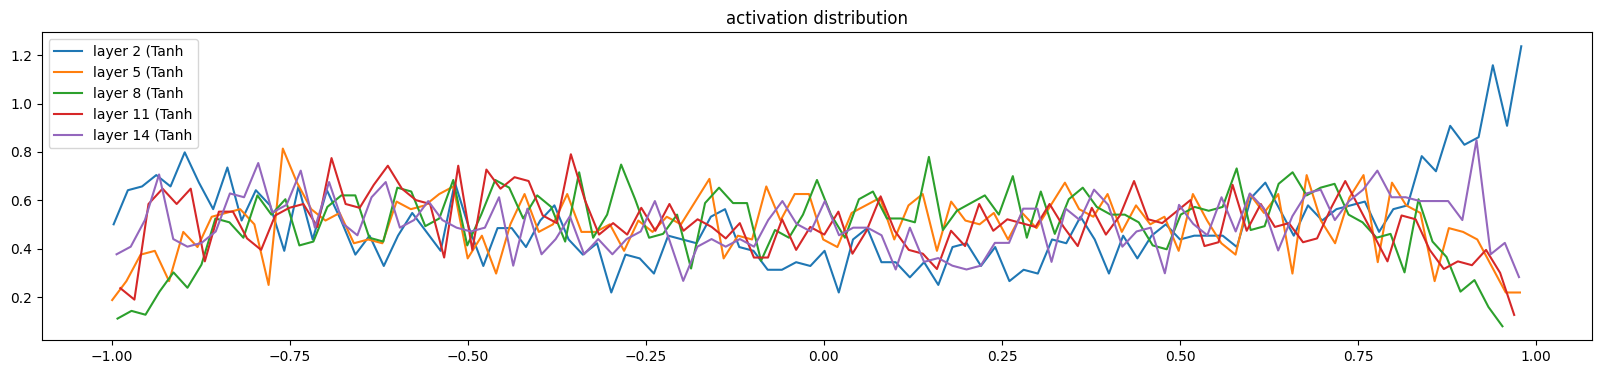

In [37]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

visualize the gradients

layer 2 (      Tanh): mean +0.000051, std 2.527910e-03
layer 5 (      Tanh): mean +0.000050, std 2.249682e-03
layer 8 (      Tanh): mean +0.000016, std 1.965734e-03
layer 11 (      Tanh): mean +0.000027, std 2.034177e-03
layer 14 (      Tanh): mean -0.000088, std 2.280425e-03


Text(0.5, 1.0, 'gradient distribution')

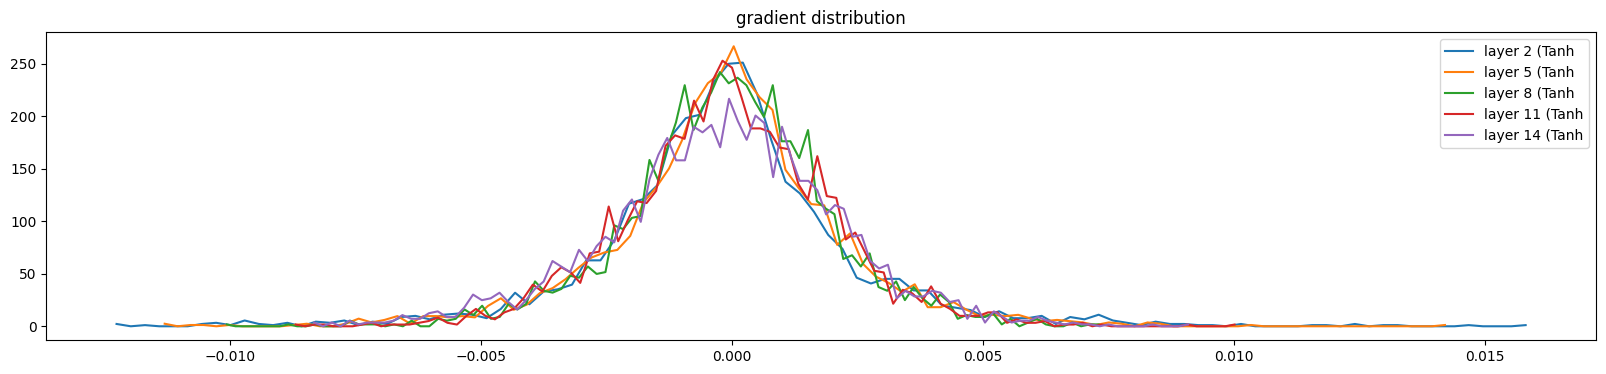

In [38]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

good alignment across all layers
- try removing batch norm, tanh and/or changing the linear layer gain and see what changes here and why that's good/bad for the training
- these are after 1000 steps; try visualizing at the first iteration?

Visualize the grad ratios for the weights parameters only (num dimensions = 2)

weight   (27, 10) | mean +0.000750 | std 8.813178e-03 | grad:data ratio 8.849567e-03
weight  (30, 100) | mean -0.000004 | std 9.428560e-03 | grad:data ratio 5.096345e-02
weight (100, 100) | mean +0.000099 | std 6.031990e-03 | grad:data ratio 5.789369e-02
weight (100, 100) | mean -0.000047 | std 4.841091e-03 | grad:data ratio 4.734855e-02
weight (100, 100) | mean -0.000006 | std 4.473118e-03 | grad:data ratio 4.359626e-02
weight (100, 100) | mean +0.000065 | std 4.892766e-03 | grad:data ratio 4.757701e-02
weight  (100, 27) | mean -0.000062 | std 1.156659e-02 | grad:data ratio 1.028499e-01


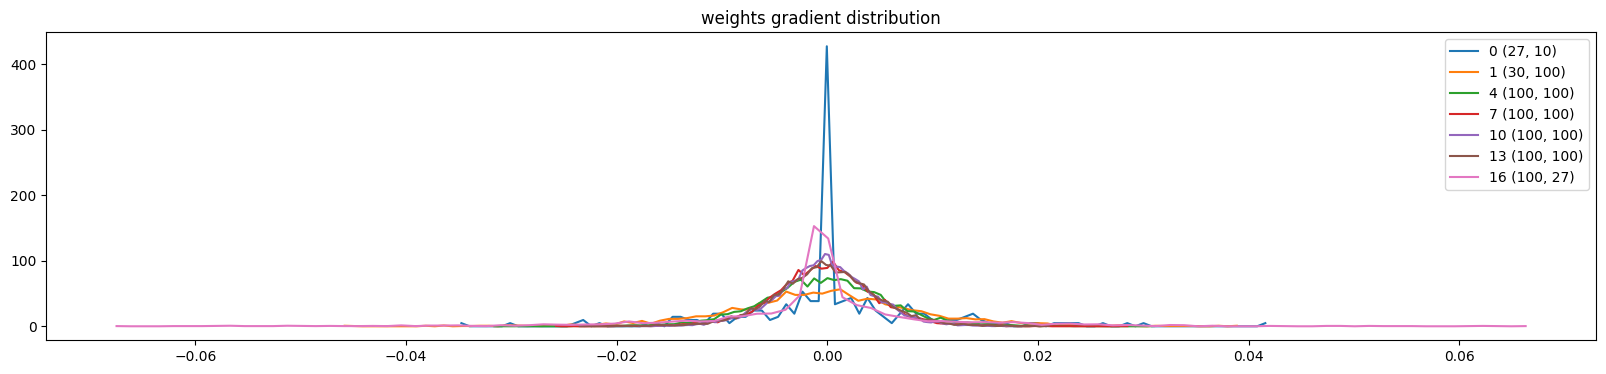

In [39]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

see how even though the last layer grads are more spread out, they are still close to 0 (max ~0.06)
why is this a good sign?

visualize the update ratios - better indicator, since that is the actual update to the data (learning_rate * grad)

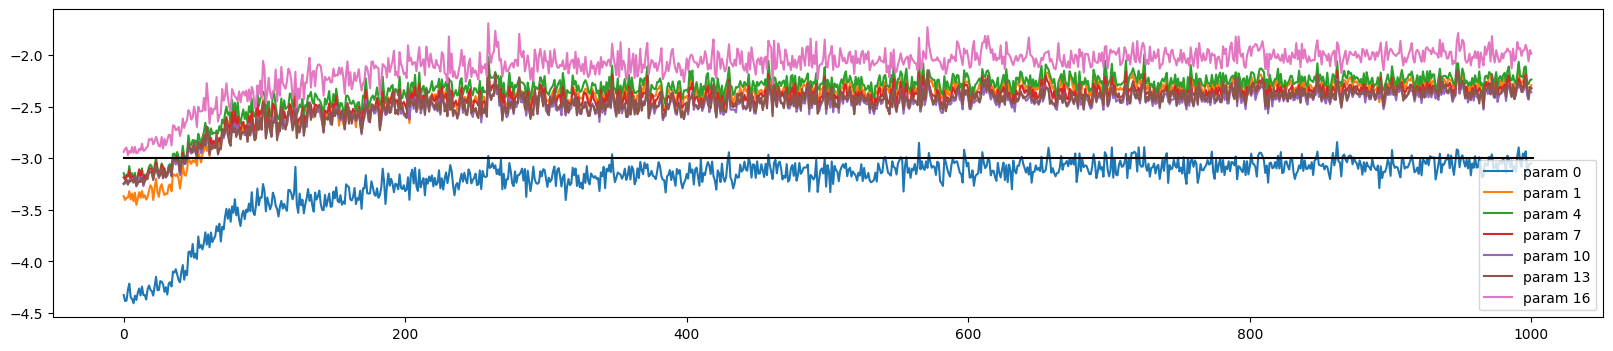

In [40]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: # take only weight parameters
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


- see how initially the update ratios were close to -3 (in log10 scale)
- later went up and stabilized
- for the last layer update ratios and grads both are on the higher end as we have made it low confidence by scaling with 0.1 (see above in forward pass)

In [42]:
@torch.no_grad()
def split_loss(split):
    X, y = {
        'train': [Xtr, ytr],
        'dev': [Xdev, ydev],
        'test': [Xtest, ytest]
    }[split]

    emb = C[X]
    x = emb.view(-1, block_size*n_emb)
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

for layer in layers:
    layer.training = False

split_loss('train') # after 1000 iterations only
split_loss('dev') # after 1000 iterations only

train 2.423678159713745
dev 2.4334933757781982


sampling 20 names after 1000 iterations learning of this deep network)

In [44]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []

    context = [0]*block_size
    while True:
        emb = C[torch.tensor(context)]
        x = emb.view(-1, block_size*n_emb)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join([itoc[i] for i in out]))

mria.
kmyaz.
seel.
ndheyala.
ethas.
ejdrleg.
aderedielii.
smi.
jelleie.
sean.
narlelyzimh.
kaa.
n.
sadbergahiries.
kin.
retelilan.
pucfiu.
zeyvdaryy.
julyeh.
ylae.


Performance is bottlenecked even after the above fixes
- we fixed activations, weights initialization, saw how batch normalization can solve for these issues
- the bottleneck is not these issues anymore or the size of the network
- bottleneck is the block_size or the context length we are giving for predicting the next token
- need to increase it and test

In [14]:
# BatchNorm forward pass as a widget
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [15]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [16]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
